<h2 align=center>Deciphering Revenue Patterns in Cinema</h2>

The script combines data exploration, visualization, and machine learning to gain valuable insights into the relationships between various factors and box office revenue in the context of the movie industry.

### Libraries

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
# nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import json
import ast
from urllib.request import urlopen
from PIL import Image

### Data Loading and Exploration

In [47]:
# Adding try-except block for reading CSV files
try:
    
    # Reading the training dataset from a CSV file into a Pandas DataFrame
    train = pd.read_csv('data/train.csv')

    # Reading the test dataset from a CSV file into a Pandas DataFrame
    test = pd.read_csv('data/test.csv') 

except FileNotFoundError as e:
    print(f'Error reading CSV files: {e}')

In [48]:
# Displaying the first few rows of the training dataset to get a quick overview
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,Keywords,revenue,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Paramount Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Columbia Pictures,production_company_Metro-Goldwyn-Mayer (MGM),production_company_New Line Cinema,production_company_Touchstone Pictures,production_company_Walt Disney Pictures,production_company_Columbia Pictures Corporation,production_company_TriStar Pictures,production_company_Relativity Media,production_company_Canal+,production_company_United Artists,production_company_Miramax Films,production_company_Village Roadshow Pictures,production_company_Regency Enterprises,production_company_BBC Films,production_company_Dune Entertainment,production_company_Working Title Films,production_company_Fox Searchlight Pictures,production_company_StudioCanal,production_company_Lionsgate,production_company_DreamWorks SKG,production_company_Fox 2000 Pictures,production_company_Summit Entertainment,production_company_Hollywood Pictures,production_company_Orion Pictures,production_company_Amblin Entertainment,production_company_Dimension Films,num_countries,production_country_United States of America,production_country_United Kingdom,production_country_France,production_country_Germany,production_country_Canada,production_country_India,production_country_Italy,production_country_Japan,production_country_Australia,production_country_Russia,production_country_Spain,production_country_China,production_country_Hong Kong,production_country_Ireland,production_country_Belgium,production_country_South Korea,production_country_Mexico,production_country_Sweden,production_country_New Zealand,production_country_Netherlands,production_country_Czech Republic,production_country_Denmark,production_country_Brazil,production_country_Luxembourg,production_country_South Africa,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,language_Italiano,language_日本語,language_普通话,language_हिन्दी,language_,language_Português,language_العربية,language_한국어/조선말,language_广州话 / 廣州話,language_தமிழ்,language_Polski,language_Magyar,language_Latin,language_svenska,language_ภาษาไทย,language_Český,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Dansk,language_Nederlands,language_فارسی,language_Tiếng Việt,language_اردو,language_Română,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,num_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,genders_0_crew,genders_1_crew,genders_2_crew,jobs_

### Visualizing the Target Distribution

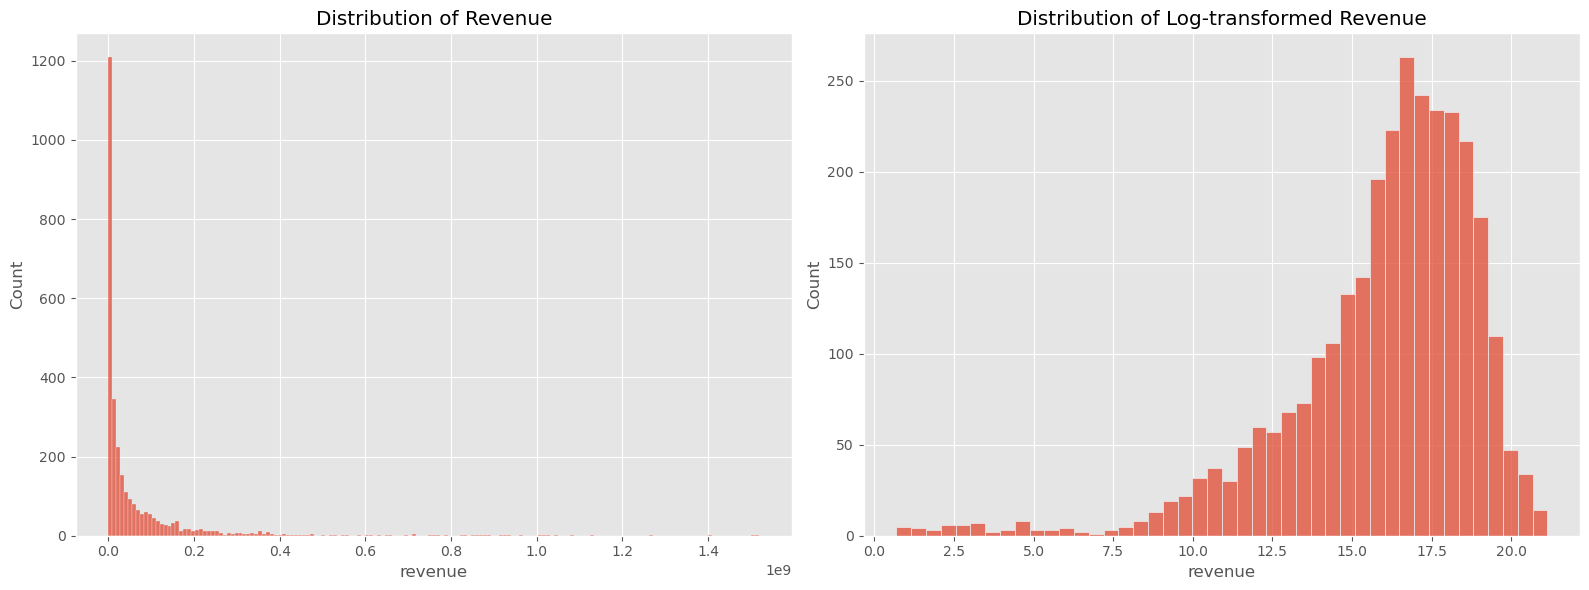

In [4]:
# Creating a subplot with two side-by-side distributions

# Setting up the figure and axes
fig, axes = plt.subplots(1,2, figsize=(16,6))

# Subplot 1: Distribution of revenue without log transformation
sns.histplot(train['revenue'], kde=False, ax=axes[0])
axes[0].set_title('Distribution of Revenue')

# Subplot 2: Distribution of log-transformed revenue
sns.histplot(np.log1p(train['revenue']), kde=False, ax=axes[1])
axes[1].set_title('Distribution of Log-transformed Revenue')

# Adjusting layout
plt.tight_layout()
plt.show()

In [5]:
# Converting 'revenue' to log scale for better visualization
# Adding a new column 'log_revenue' to the train DataFrame
# This column contains the natural logarithm (base e) plus one of the values in the 'revenue' column
train['log_revenue'] = np.log1p(train['revenue'])

### Relationship between Film Revenue and Budget

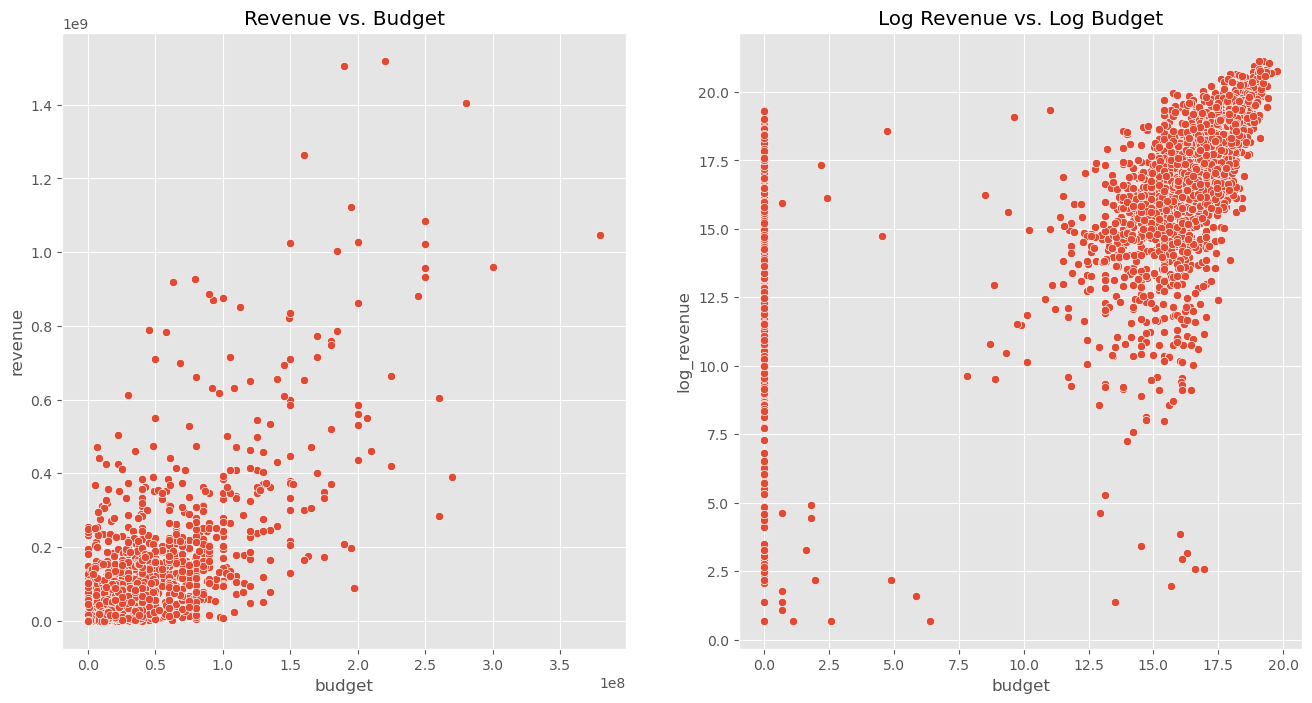

In [6]:
# Setting up the figure with a size of 16x8 inches
plt.figure(figsize=(16,8))

# Subplot 1: Scatter plot of revenue vs. budget
plt.subplot(1,2,1)
sns.scatterplot(x=train['budget'], y=train['revenue'])
plt.title('Revenue vs. Budget');

# Subplot 2: Scatter plot of log-transformed revenue vs. log-transformed budget
plt.subplot(1,2,2)
sns.scatterplot(x=np.log1p(train['budget']),y=train['log_revenue'])
plt.title('Log Revenue vs. Log Budget');

plt.show()

In [7]:
# Adding a new column 'log_budget' to the train DataFrame
# This column contains the natural logarithm (base e) plus one of the values in the 'budget' column
train['log_budget'] = np.log1p(train['budget'])

# Adding a new column 'log_budget' to the test DataFrame
# This column contains the natural logarithm (base e) plus one of the values in the 'budget' column
test['log_budget'] = np.log1p(test['budget'])

In summary, the analysis reveals a correlation between a movie's budget and its revenue. The findings suggest that the budget of a movie can influence its revenue. The observation implies that as the budget allocated to a film increases, there is a corresponding impact on its revenue. However, it's crucial to note that correlation does not imply causation, and further investigation is needed to understand the complex factors influencing the relationship between budget and revenue in the cintext of the movie industry. 

### Does having an Official Homepage Affect Revenue?

In [8]:
# Displaying the top 10 counts of 'homepage' values in the train dataset
train['homepage'].value_counts().head(10)

http://www.transformersmovie.com/                      4
http://www.thehobbit.com/                              2
http://www.lordoftherings.net/                         2
http://sonyclassics.com/whiplash/                      1
https://www.facebook.com/thefinesthoursmovie           1
http://sonyclassics.com/pariscanwait/                  1
http://www.maxpaynethemovie.com                        1
http://www.sonypictures.com/movies/afewgoodmen/        1
http://www.theasylum.cc/product.php?id=203             1
http://www.miramax.com/movie/the-cider-house-rules/    1
Name: homepage, dtype: int64

In [9]:
# Creating a biunary indicator column 'has_homepage' based on the presence of an official homepage

# Initializing 'has_homepage' column with zeros for both train and test DataFrame
train['has_homepage'] = 0
test['has_homepage'] = 0

# Updating 'has_homepage' to 1 for movies with an official homepage in the train DataFrame
train.loc[train['homepage'].notnull(), 'has_homepage'] = 1

# Updating 'has_homepage' to 1 for movies with an official homepage in the test DataFrame
test.loc[test['homepage'].notnull(), 'has_homepage'] = 1

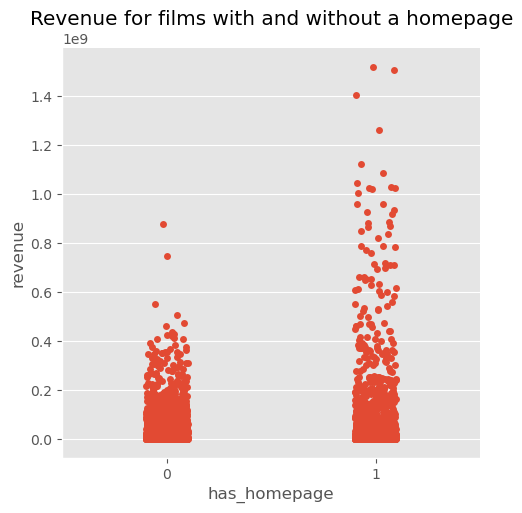

In [10]:
#Visualizing the relationship betweeb having a homepage and movie revenue
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for films with and without a homepage');

In summary, movies without official homepages tend to generate lower revenue. The introduction of the binary feature 'has_homepage' reveals a predictive pattern - movies with homepages generally exhibit higher revenue. This observation suggests that the presence of an official homepage may positively impact revenue, potentially because it allows viewers to learn more about the film and become invested in the story. The data indicates a correlation between having an official homepage and higher movie revenue. 

### Distribution of Languages in Film

In [11]:
# Selecting data for the top 10 most frequent languages
language_data = train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]

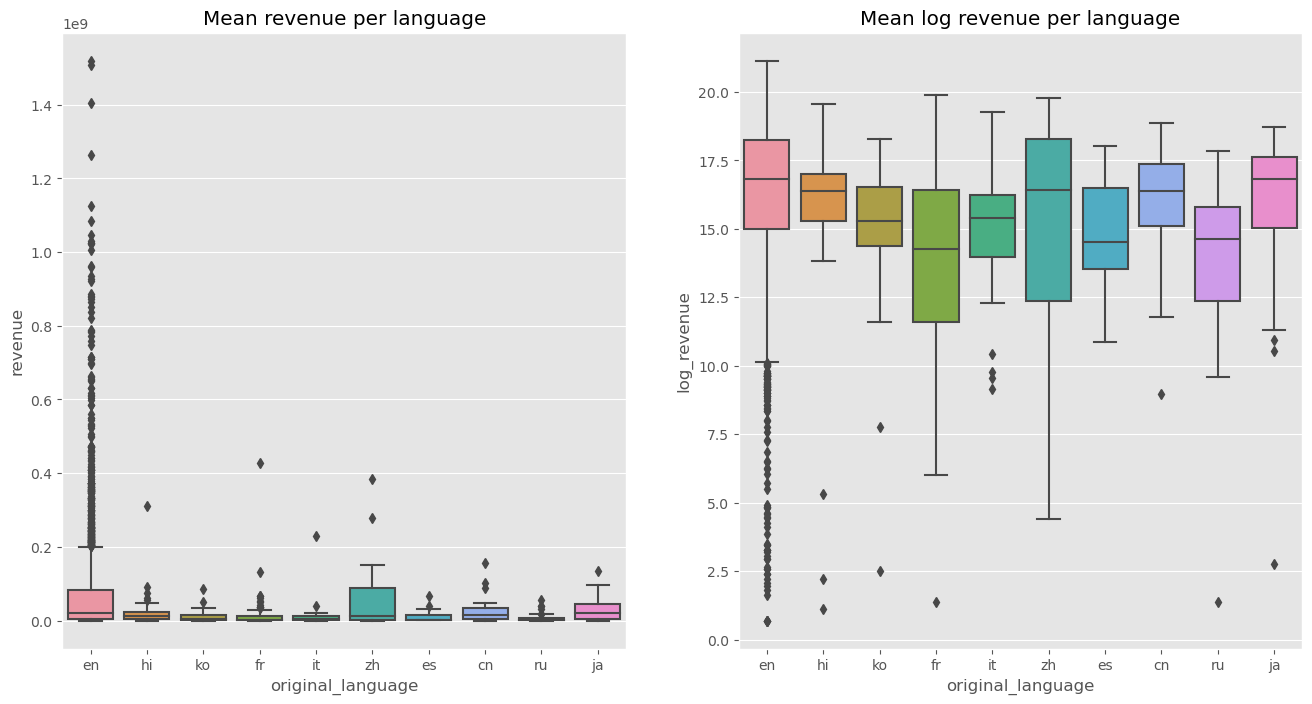

In [12]:
# Boxplot to analyze the impact of language in revenue
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.boxplot(x='original_language', y='revenue', data=language_data)
plt.title('Mean revenue per language')
plt.subplot(1,2,2)
sns.boxplot(x='original_language', y='log_revenue', data=language_data)
plt.title('Mean log revenue per language');

The distribution of languages in films demonstrates a substantial impact on revenue. English-language films, being more prolific in our dataset, contribute to a wider range of revenue values. While it may appear that English overshadows every other language, closer inspection reveals a nuanced perspective. Despite the dominance of English, films in other languages still contribute significantr value and revenue. It's crucial to recognize the diversity in languages as essential aspects of the film industry, with each language adding its unique cultural and financial contribvution. In summary, while English consistently leads in revenue, films in other languages continue to play a vital role in contributing value to the industry. 

### Frequent Words in Film Titles and Descriptions

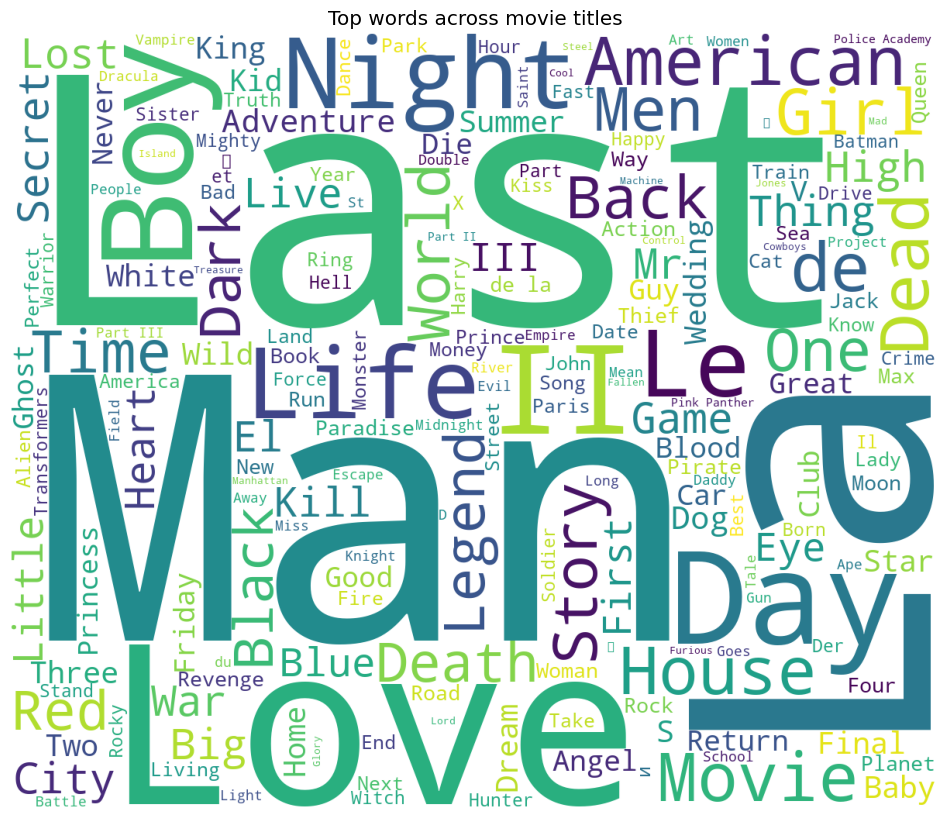

In [13]:
# Creating a word cloud to vsualize the most frequent words in movie titles

# Setting the size of the figure
plt.figure(figsize=(12,12))

# Concatenating all movie titles into a single text string
text = ' '.join(train['original_title'].values)

# Generating the word cloud 
wordcloud = WordCloud(max_font_size = None, background_color='white', width=1200, height=1000).generate(text)

plt.imshow(wordcloud)
plt.title('Top words across movie titles')
plt.axis('off')
plt.show()

In [14]:
# Extracting and counting words for the top 10 most frequent words
words = wordcloud.process_text(text)
top_words = dict(sorted(words.items(), key=lambda x: x[1], reverse=True)[:10])

# Printing the top 10 most frequent words
print("Top 10 most frequent words in the Title:")
for word, count in top_words.items():
    print(f"{word}: {count}")

Top 10 most frequent words in the Title:
Man: 34
Last: 30
La: 28
Love: 26
Day: 24
Boy: 23
II: 22
Night: 21
Life: 21
Le: 19


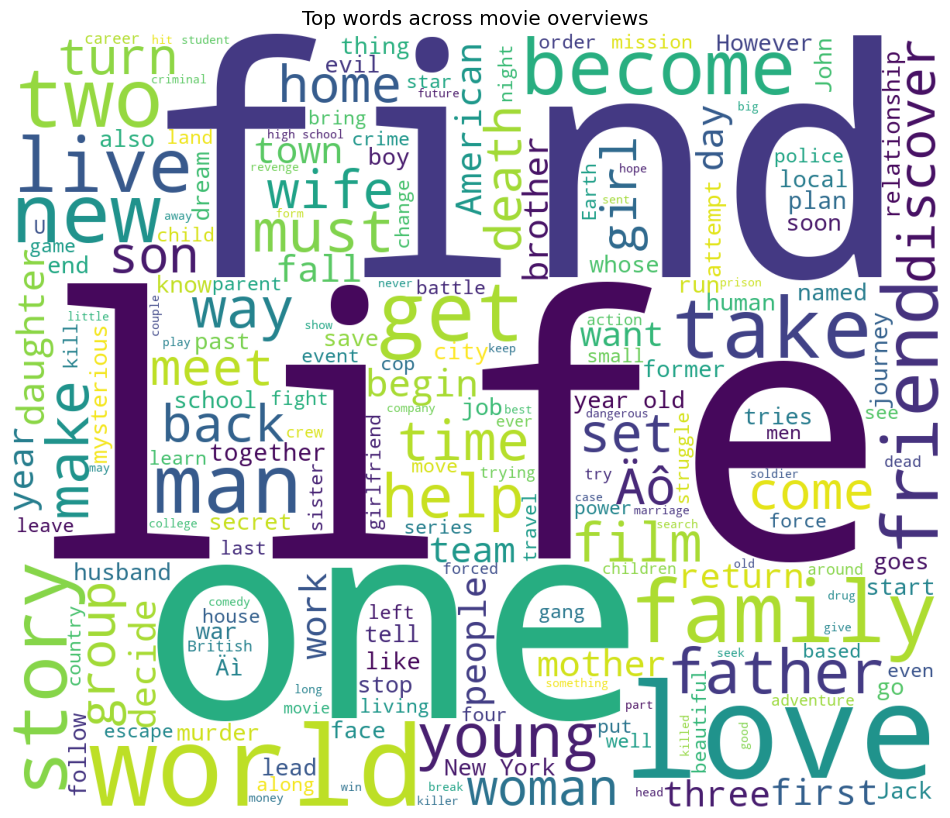

In [15]:

# Setting the size of the figure
plt.figure(figsize=(12, 12))

# Concatenating all movie overviews into a single text string
text = ' '.join(train['overview'].fillna('').values)

# Generating the word cloud with stopwords removed
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000, stopwords=set(stopwords.words('english'))).generate(text)

# Displaying the word cloud
plt.imshow(wordcloud)
plt.title('Top words across movie overviews')
plt.axis('off')
plt.show()


In [16]:
import re

## Extracting and counting words using Counter and regular expressions, excluding stopwords
stopwords_set = set(stopwords.words('english'))
words = [word.lower() for word in re.findall(r'\b\w+\b', text) if word.lower() not in stopwords_set]
word_counts = Counter(words)
top_words = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10])

# Printing the top 10 most frequent words in movie overviews
print("Top 10 most frequent words in movie overviews (excluding common stopwords):")
for word, count in top_words.items():
    print(f"{word}: {count}")


Top 10 most frequent words in movie overviews (excluding common stopwords):
life: 607
new: 417
one: 412
young: 394
man: 361
world: 349
love: 345
two: 335
story: 308
family: 308


Both visualizations offer a quick and visually appealing way to explore the most frequent words in movie titles and overviews, providing insights into common themes or topics in the dataset. The frequent words in titles seem to include terms like "Man", "Last", "Love", and "Life," suggesting potential themes or genres. The overviews, after excluding common stopwords, highlight words such as "life", "new", "love" and "family," providing a glimpse into the central themes of the movies.

### Do Film Descriptions Impact Revenue?

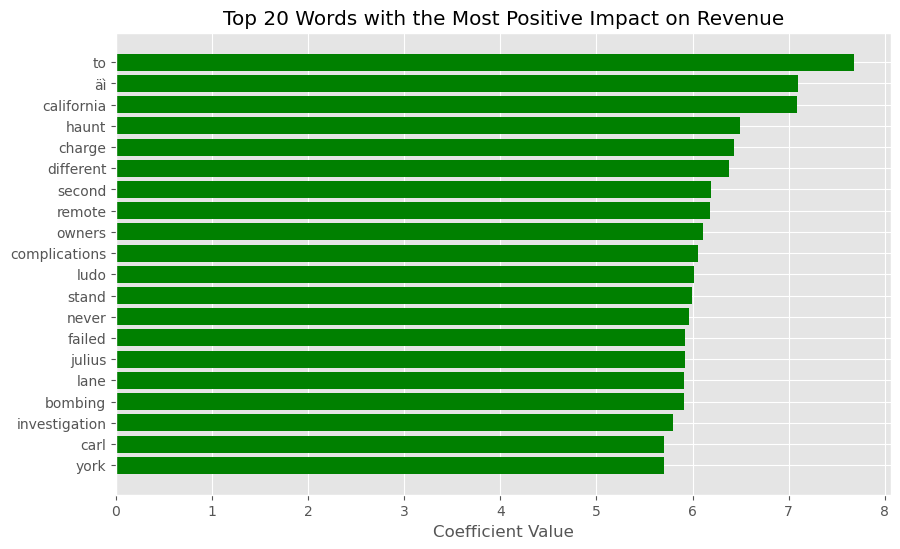

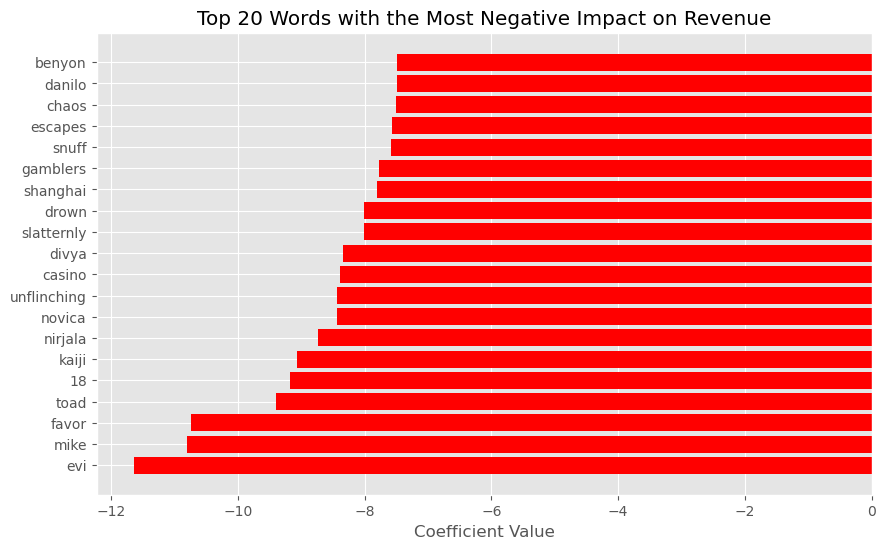

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Assuming 'overview' contains film descriptions and 'log_revenue' contains revenue in log scale
X = train['overview'].fillna('')
y = train['log_revenue']

# Create a pipeline with TfidfVectorizer and Linear Regression
model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('regression', LinearRegression())
])

# Train the pipeline
model_pipeline.fit(X, y)

# Get the coefficients from the linear regression model
coefficients = model_pipeline.named_steps['regression'].coef_
feature_names = model_pipeline.named_steps['tfidf'].get_feature_names_out()

# Sort coefficients and feature names
sorted_indices = np.argsort(coefficients)

# Get the top 20 positive and negative coefficients and feature names
top_positive_indices = sorted_indices[-20:]
top_negative_indices = sorted_indices[:20]

top_positive_coefficients = coefficients[top_positive_indices]
top_negative_coefficients = coefficients[top_negative_indices]

top_positive_feature_names = np.array(feature_names)[top_positive_indices]
top_negative_feature_names = np.array(feature_names)[top_negative_indices]

# Plot the top positive coefficients
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(top_positive_feature_names)), top_positive_coefficients, color='green', align='center')
ax.set_yticks(range(len(top_positive_feature_names)))
ax.set_yticklabels(top_positive_feature_names)
ax.set_xlabel('Coefficient Value')
ax.set_title('Top 20 Words with the Most Positive Impact on Revenue')
plt.show()

# Plot the top negative coefficients
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(top_negative_feature_names)), top_negative_coefficients, color='red', align='center')
ax.set_yticks(range(len(top_negative_feature_names)))
ax.set_yticklabels(top_negative_feature_names)
ax.set_xlabel('Coefficient Value')
ax.set_title('Top 20 Words with the Most Negative Impact on Revenue')
plt.show()


The analysis indicates that film descriptions do impact revenue, and certain words used in movie descriptions can be predictive of revenue. The top 20 words with the most positive impact on revenue include terms like "ai," "California," "haunt," and "charge." Conversely, the top 20 words with the most negative impact on revenue include terms like "favor," "18," "unflinching," "casino," "slatternly."

This suggests that specific words related to the content and theme of the movie may influence audience interest and, consequently, the film's revenue. Filmmakers and marketers could potentially leverage these insights to optimize movie descriptions for better financial outcomes.

### Conclusion

- The analysis suggests associations between several factors (budget, homepage presence, language, and word usage in descriptions) and movie revenue.

- Filmmakers and marketers can potentially leverage these insights to optimize their strategies for better financial outcomes.
